### Домашнее задание 2

Выполнил Козин Роман

Для начала отберём 10 классов для работы с ними

In [23]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np

In [47]:
import random
import torch
random.seed(52)
torch.manual_seed(52)
np.random.seed(52)
CLASS_NUM = 10
classes_path = './data/tiny-imagenet-200/tiny-imagenet-200/wnids.txt'
with open(classes_path) as f:
    ids = f.read().split('\n')
print(ids)

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', 'n02165456'

Возьмём случайные десять классов, в исходном текстовом файле была пустая строка, учтём это при отборе случайных классов

In [2]:
selected_classes = random.sample(ids[:-1], CLASS_NUM)
print(selected_classes)

['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']


Вот наши классы, чтобы случайно не потерять их, выпишем их в список явно

In [3]:
selected_classes = ['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']

## Часть 1: Подготовка данных

Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

* Метод ```__init__```: инициализация путей к данным, загрузка списка изображений и меток
* Метод ```__len__```: возврат количества примеров в датасете
* Метод ```__getitem__```: загрузка и возврат одного примера (изображение + метка)

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch
import os
class SmallDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, device = torch.device("cpu"), transform = None) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        if ds_type == 'val':
            self.prepareValData()
        self.device = device
        self.transform = transform
        self.label_to_idx = {label : idx for idx, label in enumerate(classes)}
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def __getitem__(self, index: int):
        if self.ds_type == 'val':
            data = self.valData[index]
            img_path = os.path.join(self.root, self.ds_type, "images", data[0])
            label = data[1]
            bbox = tuple(data[2:])
        else:
            label_idx = index // 500
            img_idx = index % 500
            label = self.classes[label_idx]
            label_root = os.path.join(self.root, self.ds_type, label)
            img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
            with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                rows = f.readlines()
                f.close()
            row = rows[img_idx]
            data = self._parseLine(row)
            bbox = tuple(data[1:])
        
        bbox = torch.tensor(bbox).to(self.device)
        img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
        return (img.to(self.device), torch.tensor(self.label_to_idx[label]).to(self.device), bbox)
        
    def __len__(self) -> int:
        #структура исходного датасета такова, что на каждый класс приходится 500 изображений
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)

In [5]:
ds = SmallDataset("data\\tiny-imagenet-200\\tiny-imagenet-200", classes=selected_classes, ds_type='train')

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

Создайте базовый residual блок со следующей структурой:

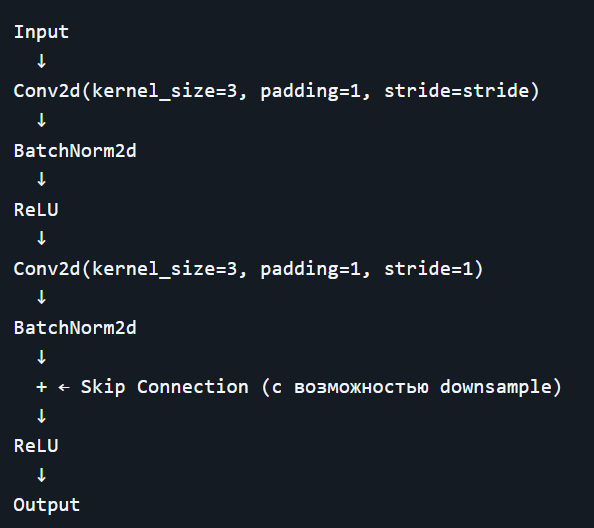

Важно:

* Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
* Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [10]:
import torch.nn as nn

class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.relu(res)
        return res

In [47]:
x = torch.randn(1, 3, 64, 64)

model = BasicResBlock(3, 16, stride=2)
print(model(x).shape)

torch.Size([1, 16, 32, 32])


### 2.2 Реализация ResNet18

Создайте архитектуру ResNet18 со следующей структурой:

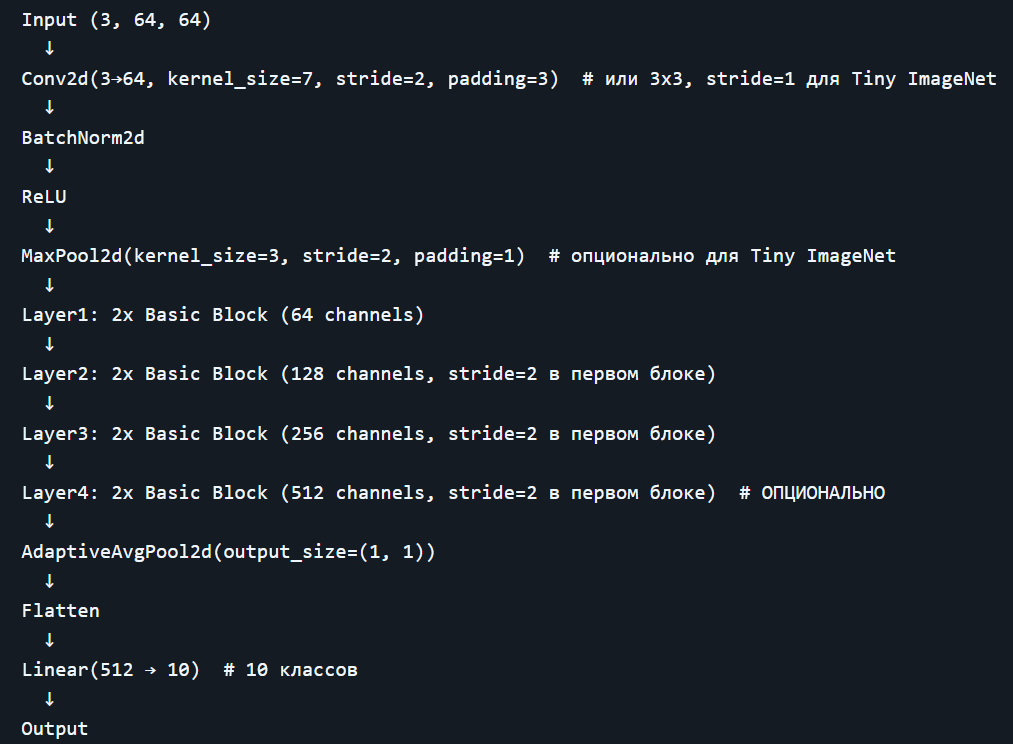

Сделаем без самой первой свёртки, так как она необязательная

In [11]:
class ResNet18(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(    #64, 32, 32
            BasicResBlock(in_channels=3, out_channels=3, stride=2),
            BasicResBlock(in_channels=3, out_channels=64, stride=1),
        )
        self.layer2 = nn.Sequential(    #128, 16, 16
            BasicResBlock(in_channels=64, out_channels=64, stride=2),
            BasicResBlock(in_channels=64, out_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(    #256, 8, 8
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        self.layer4 = nn.Sequential(    #512, 4, 4
            BasicResBlock(in_channels=256, out_channels=256, stride=2),
            BasicResBlock(in_channels=256, out_channels=512, stride=1)
        )
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg(self.layer4(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [6]:
from torchsummary import summary

In [57]:
x = torch.randn((1, 3, 64, 64))
model = ResNet18()
print(model(x).shape)
summary(model, input_size=(3, 64, 64), batch_size=1)

torch.Size([1, 10])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

Итого параметров меньше 5 млн. Важно отметить, что условие на число параметров удалось соблюсти благодаря тому, что изменение количества каналов происходит в последнем блоке. То же самое происходит внутри базового блока, каналы изменяются в последней свёртке. Для простоты сравнения будем везде придерживаться такой структуры

### Обучение

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

In [ ]:
torch.manual_seed(52)


transforms_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "./data/tiny-imagenet-200/tiny-imagenet-200"
train_data = SmallDataset(root=data_root, classes=selected_classes,
                          ds_type='train', transform=transforms_list, device=device)
val_data = SmallDataset(root=data_root, classes=selected_classes,
                        ds_type='val', transform=transforms_list, device=device)
train_data_loader = DataLoader(train_data,batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=True)
model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Цикл обучения

In [13]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
EPOCH_NUM = 20
for epoch in range(EPOCH_NUM):
    train_correct = 0
    train_predicted = 0
    model.train()
    
    for images, labels, _ in tqdm(desc=f"Training epoch {epoch +1}", iterable=train_data_loader):
        optimizer.zero_grad()
        # print(labels)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        preds = logits.argmax(dim=-1)
        train_correct += (preds==labels).sum().item()
        train_predicted += labels.size(0)
        
    train_loss_history.append(loss.item())
    train_acc_history.append(train_correct / train_predicted)
    
    model.eval()
    val_correct = 0
    val_predicted = 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
            logits = model(images)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            val_correct += (preds==labels).sum().item()
            val_predicted += labels.size(0)
            
        val_loss_history.append(loss.item())
        val_acc_history.append(val_correct / val_predicted)

Validating: 100%|██████████| 32/32 [00:00<00:00, 65.34it/s]


In [30]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np

[]

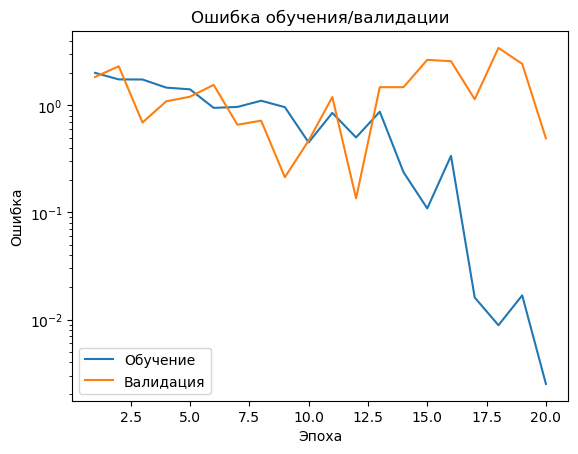

In [15]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), train_loss_history, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), val_loss_history, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

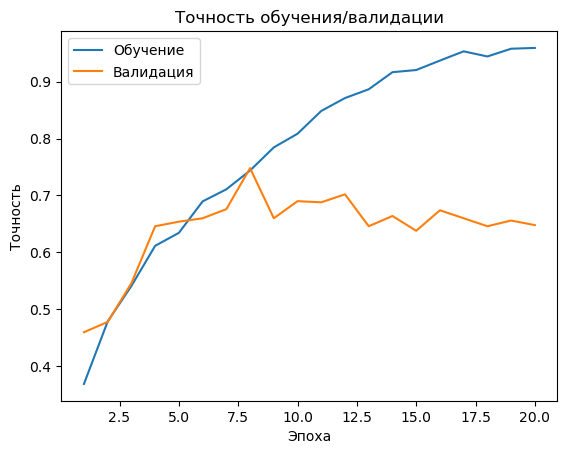

In [16]:
plt.title('Точность обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), train_acc_history, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), val_acc_history, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

### Наблюдение

На графике ошибке по эпохам сложно увидеть, происходит обучение или нет, но если смотреть на точность, то можно увидеть, что точность растёт при обучении, но точность валидации в один момент выходит на плато. Момент выхода на плато можно взять как итоговую модель. Чтобы проверить, что ошибка снижается, построим график ошибки на каждой итерации

In [17]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
EPOCH_NUM = 20
model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(EPOCH_NUM):
    train_correct = 0
    train_predicted = 0
    model.train()
    
    for images, labels, _ in tqdm(desc=f"Training epoch {epoch +1}", iterable=train_data_loader):
        optimizer.zero_grad()
        # print(labels)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        preds = logits.argmax(dim=-1)
        train_correct += (preds==labels).sum().item()
        train_predicted += labels.size(0)
            
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)
    
    model.eval()
    val_correct = 0
    val_predicted = 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
            logits = model(images)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            val_correct += (preds==labels).sum().item()
            val_predicted += labels.size(0)
            
            val_loss_history.append(loss.item())
            val_acc_history.append(val_correct / val_predicted)

Validating: 100%|██████████| 32/32 [00:00<00:00, 65.66it/s]


[]

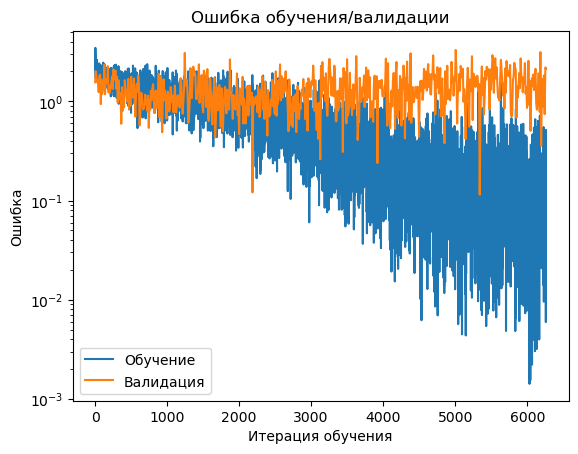

In [18]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, len(train_loss_history)+1, dtype=np.int16), train_loss_history, label='Обучение')
plt.plot(np.linspace(start=1, stop=len(train_loss_history)+1, num=len(val_loss_history), endpoint=True), val_loss_history, label='Валидация')
plt.xlabel('Итерация обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

Здесь тоже можно видеть, что в один момент ошибка валидации начинает колебаться около определённого значения и больше не опускается, это происходит примерно на итерации 2000-3000

Итоговая модель на этом этапе:

In [19]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

## 3 Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

Цель: Изучение влияния количества каналов на производительность.

Эксперимент:

Создайте 2 варианта модели:
* Вариант A: 32 → 64 → 128 → 256 каналов
* Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

Обучите обе модели с теми же гиперпараметрами

Сравните:
* Количество параметров
* Validation accuracy

In [20]:
class ResNetA(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(    #32, 32, 32
            BasicResBlock(in_channels=3, out_channels=3, stride=2),
            BasicResBlock(in_channels=3, out_channels=32, stride=1),
        )
        self.layer2 = nn.Sequential(    #64, 16, 16
            BasicResBlock(in_channels=32, out_channels=32, stride=2),
            BasicResBlock(in_channels=32, out_channels=64, stride=1)
        )
        self.layer3 = nn.Sequential(    #128, 8, 8
            BasicResBlock(in_channels=64, out_channels=64, stride=2),
            BasicResBlock(in_channels=64, out_channels=128, stride=1)
        )
        
        self.layer4 = nn.Sequential(    #256, 4, 4
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg(self.layer4(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [21]:
summary(ResNetA())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              960
|    |    └─Sequential: 3-7              192
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              9,312
|    |    └─Sequential: 3-10             9,312
|    |    └─Sequential: 3-11             1,120
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             9,312
|    |    └─Sequential: 3-14             18,624
|    |    └─Sequential: 3-15             2,240
|    |

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              960
|    |    └─Sequential: 3-7              192
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              9,312
|    |    └─Sequential: 3-10             9,312
|    |    └─Sequential: 3-11             1,120
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             9,312
|    |    └─Sequential: 3-14             18,624
|    |    └─Sequential: 3-15             2,240
|    |

In [ ]:
model = ResNetA().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [13]:
def trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, epoch_num=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    for epoch in range(epoch_num):
        train_correct = 0
        train_predicted = 0
        model.train()
        
        for images, labels, _ in tqdm(desc=f"Training epoch {epoch +1}", iterable=train_data_loader):
            optimizer.zero_grad()
            # print(labels)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = logits.argmax(dim=-1)
            train_correct += (preds==labels).sum().item()
            train_predicted += labels.size(0)
            
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)
        
        model.eval()
        val_correct = 0
        val_predicted = 0
        
        with torch.no_grad():
            for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
                logits = model(images)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                val_correct += (preds==labels).sum().item()
                val_predicted += labels.size(0)
                
            val_loss_history.append(loss.item())
            val_acc_history.append(val_correct / val_predicted)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [24]:
model_a, a_train_loss, a_val_loss, a_train_acc, a_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader)

Validating: 100%|██████████| 32/32 [00:00<00:00, 63.82it/s]


In [29]:
class ResNetB(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(    #64, 32, 32
            BasicResBlock(in_channels=3, out_channels=3, stride=2),
            BasicResBlock(in_channels=3, out_channels=64, stride=1),
        )
        self.layer2 = nn.Sequential(    #128, 16, 16
            BasicResBlock(in_channels=64, out_channels=64, stride=2),
            BasicResBlock(in_channels=64, out_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(    #256, 8, 8
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [30]:
summary(ResNetB())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

In [ ]:
model = ResNetB().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [32]:
model_b, b_train_loss, b_val_loss, b_train_acc, b_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader)

Validating: 100%|██████████| 32/32 [00:00<00:00, 62.23it/s]


Сперва посмотрим на обучение каждой из моделей отдельно

### Модель А

[]

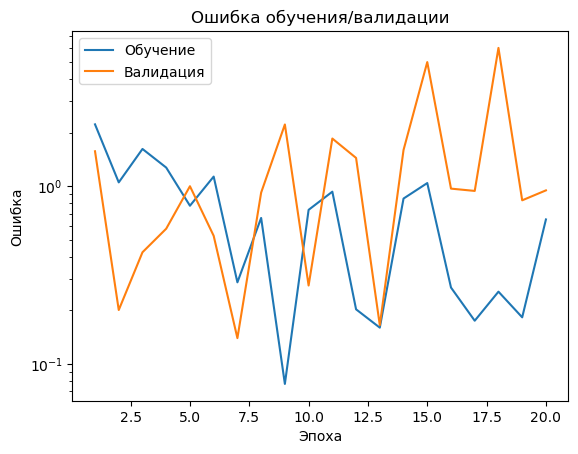

In [33]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_train_loss, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_val_loss, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

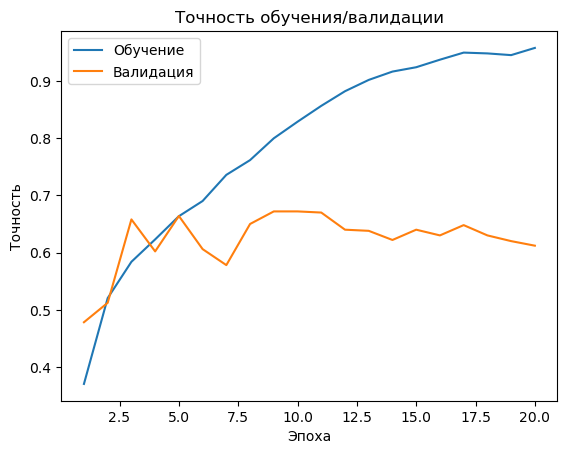

In [34]:
plt.title('Точность обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_train_acc, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_val_acc, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

Если сравнить с первой версией, то результаты похожи

### Модель В

[]

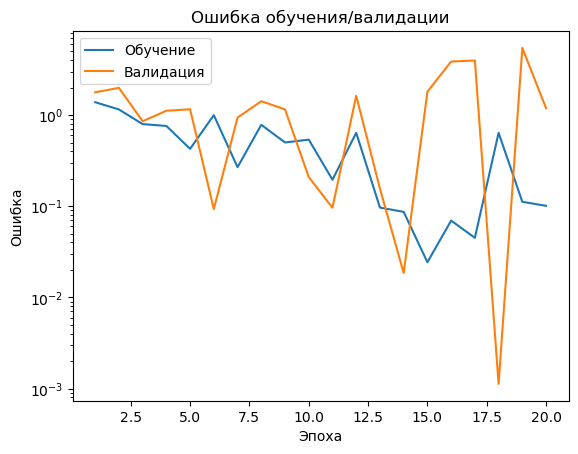

In [35]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), b_train_loss, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), b_val_loss, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

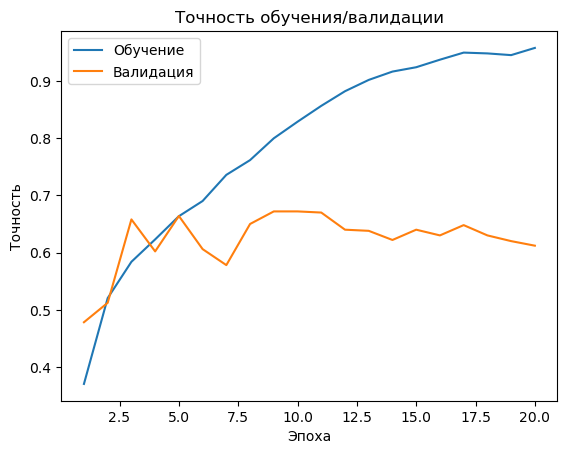

In [36]:
plt.title('Точность обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_train_acc, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_val_acc, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

Сравним валидацию двух моделей: ошибку и точность

[]

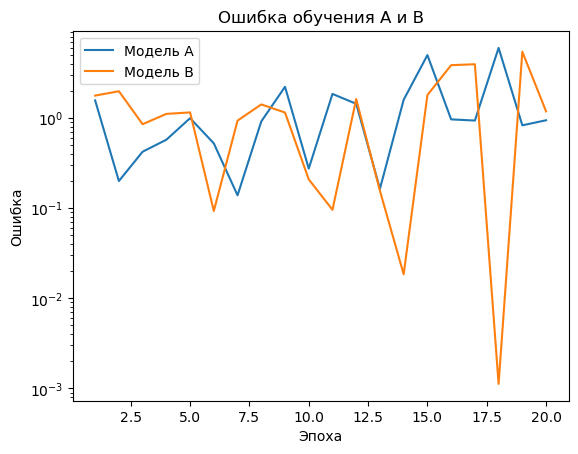

In [37]:
plt.title('Ошибка обучения А и В')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_val_loss, label='Модель А')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), b_val_loss, label='Модель В')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

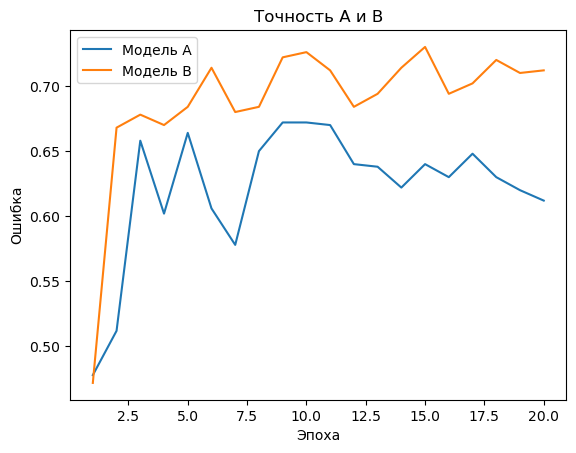

In [38]:
plt.title('Точность А и В')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), a_val_acc, label='Модель А')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), b_val_acc, label='Модель В')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
# plt.semilogy()

По графику модель B оказалась лучше. Чтобы однозначно выбрать лучшую модель по точности на валидации, модифицируем код обучения

In [14]:
def trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, save_name, epoch_num=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_accuracy = None
    for epoch in range(epoch_num):
        train_correct = 0
        train_predicted = 0
        model.train()
        
        for images, labels, _ in tqdm(desc=f"Training epoch {epoch +1}", iterable=train_data_loader):
            optimizer.zero_grad()
            # print(labels)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = logits.argmax(dim=-1)
            train_correct += (preds==labels).sum().item()
            train_predicted += labels.size(0)
            
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)
        
        model.eval()
        val_correct = 0
        val_predicted = 0
        
        with torch.no_grad():
            for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
                logits = model(images)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                val_correct += (preds==labels).sum().item()
                val_predicted += labels.size(0)
            accuracy = val_correct / val_predicted
            if best_accuracy is None or best_accuracy < accuracy:
                best_accuracy = accuracy
                torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : model.state_dict(),
                }, os.path.join(".", "models", "hw2", f'{save_name}_best.pth'))
            val_loss_history.append(loss.item())
            val_acc_history.append(val_correct / val_predicted)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [ ]:
model = ResNetA().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_a, a_train_loss, a_val_loss, a_train_acc, a_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, save_name="modelA")

Validating: 100%|██████████| 32/32 [00:00<00:00, 61.25it/s]


In [ ]:
model = ResNetB().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_b, b_train_loss, b_val_loss, b_train_acc, b_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, save_name="modelB")

Validating: 100%|██████████| 32/32 [00:00<00:00, 64.14it/s]


Сравним лучшие модели по качеству

In [42]:
checkpoint = torch.load('./models/hw2/modelA_best.pth', map_location='cuda')
model_a = ResNetA()
model_a.to(device)
model_a.load_state_dict(checkpoint['model_state_dict'])
model_a.eval()  

checkpoint = torch.load('./models/hw2/modelB_best.pth', map_location='cuda')
model_b = ResNetB()
model_b.to(device)
model_b.load_state_dict(checkpoint['model_state_dict'])
model_b.eval()  

ResNetB(
  (layer1): Sequential(
    (0): BasicResBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Sequential(
        (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): BasicResBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(

In [39]:
def calcAccuracy(model, val_data_loader):
    val_correct = 0
    val_predicted = 0
    with torch.no_grad():
        for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
            logits = model(images)
            preds = logits.argmax(dim=-1)
            val_correct += (preds==labels).sum().item()
            val_predicted += labels.size(0)
        accuracy = val_correct / val_predicted
    return accuracy

In [ ]:
acc_a = calcAccuracy(model_a, val_data_loader)
acc_b = calcAccuracy(model_b, val_data_loader)

Validating: 100%|██████████| 32/32 [00:00<00:00, 64.65it/s]


In [45]:
print("Точность модели А:", acc_a)
print("Точность модели B", acc_b)

Точность модели А: 0.688
Точность модели B 0.72


### Сравнительная таблица

| Модель | Параметры | Точность |
|---|---:|---:|
| ResNetA | 1,041,578 | 68.8% |
| ResNetB | 992,810 | 72.0% |


По итогу модель B оказалась получше

Можно сделать вывод, что менее глубокая модель, но с тем же количеством итоговых признаков (каналов) перед применением линейного слоя, оказалась эффективнее. Это может быть связано с тем, что первые слои имеют более обширные признаки. При этом мы не сильно изменили количество параметров (на 5%).

### 3.2: Эксперименты с количеством residual блоков

Цель: Изучение влияния глубины сети (количества residual блоков) на производительность.

Эксперимент:

Используйте лучшую конфигурацию каналов из Этапа 3.1

Создайте 3 варианта модели с разным количеством блоков в каждом слое:
* Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
* Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
* Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)

Обучите все три модели с одинаковыми гиперпараметрами

За основу возьмём модель B, будем использовать три слоя и менять количество блоков в каждом из слоёв. Сделаем следующим образом: в первом блоке снижаем разрешение изображения, а в последующих нет. Количество каналов изменяем только в последнем слое (как было оговорено при моей реализации ResNet18)

In [26]:
class ShallowLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = BasicResBlock(in_channels, out_channels, stride=2)
        
    def forward(self, x):
        return self.layer(x)

class ShallowResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = ShallowLayer(in_channels=3, out_channels=64) #64, 32, 32
        self.layer2 = ShallowLayer(in_channels=64, out_channels=128) #128 16, 16
        self.layer3 = ShallowLayer(in_channels=128, out_channels=256) # 256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [27]:
model = ShallowResNet()
param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Число параметров: ", param_num)

Число параметров:  601764


In [28]:
class MidLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, in_channels, stride=2),
            BasicResBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.layer(x)
    
class MidResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = MidLayer(3, 64) #64, 32, 32
        self.layer2 = MidLayer(64, 128) #128, 16, 16
        self.layer3 = MidLayer(128, 256) #256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [29]:
model = MidResNet()
param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Число параметров: ", param_num)

Число параметров:  992810


In [30]:
class DeepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, in_channels, stride=2),
            BasicResBlock(in_channels, in_channels),
            BasicResBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.layer(x)
    
class DeepResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = DeepLayer(3, 64) #64, 32, 32
        self.layer2 = DeepLayer(64, 128) #128, 16, 16
        self.layer3 = DeepLayer(128, 256) #256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [31]:
model = DeepResNet()
param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Число параметров: ", param_num)

Число параметров:  1362782


Теперь обучим все модели

In [32]:
EPOCH_NUM = 20

In [ ]:
model = ShallowResNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_shallow, shallow_train_loss, shallow_val_loss, shallow_train_acc, shallow_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, save_name="shallow")

Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validating: 100%|██████████| 32/32 [00:00<00:00, 56.91it/s]


In [ ]:
model = MidResNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_mid, mid_train_loss, mid_val_loss, mid_train_acc, mid_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, save_name="mid")

Validating: 100%|██████████| 32/32 [00:00<00:00, 53.22it/s]


In [ ]:
model = DeepResNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_deep, deep_train_loss, deep_val_loss, deep_train_acc, deep_val_acc = trainModel(model, optimizer, criterion, train_data_loader, val_data_loader, save_name="deep")

Validating: 100%|██████████| 32/32 [00:00<00:00, 50.50it/s]


In [37]:
checkpoint = torch.load('./models/hw2/shallow_best.pth', map_location='cuda')
model_shallow = ShallowResNet()
model_shallow.to(device)
model_shallow.load_state_dict(checkpoint['model_state_dict'])
model_shallow.eval()  

checkpoint = torch.load('./models/hw2/mid_best.pth', map_location='cuda')
model_mid = MidResNet()
model_mid.to(device)
model_mid.load_state_dict(checkpoint['model_state_dict'])
model_mid.eval()

checkpoint = torch.load('./models/hw2/deep_best.pth', map_location='cuda')
model_deep = DeepResNet()
model_deep.to(device)
model_deep.load_state_dict(checkpoint['model_state_dict'])
model_deep.eval()

DeepResNet(
  (layer1): DeepLayer(
    (layer): Sequential(
      (0): BasicResBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (downsample): Sequential(
          (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (activation): ReLU()
      )
      (1): BasicResBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [40]:
acc_shallow = calcAccuracy(model_shallow, val_data_loader)
acc_mid = calcAccuracy(model_mid, val_data_loader)
acc_deep = calcAccuracy(model_deep, val_data_loader)

Validating: 100%|██████████| 32/32 [00:00<00:00, 33.52it/s]


In [41]:
print("Неглубокая сеть: ", acc_shallow)
print("Средняя сеть: ", acc_mid)
print("Глубокая сеть: ", acc_deep)

Неглубокая сеть:  0.756
Средняя сеть:  0.744
Глубокая сеть:  0.718


Построим графики точности

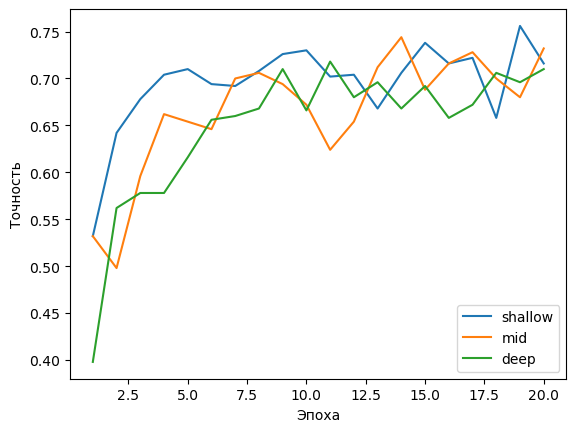

In [42]:
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), shallow_val_acc, label = 'shallow')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), mid_val_acc, label = 'mid')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), deep_val_acc, label = 'deep')
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()

Эпоха наилучшего результата:

In [43]:
print("shallow: ", np.argmax(shallow_val_acc) + 1)
print("mid: ", np.argmax(mid_val_acc) + 1)
print("deep: ", np.argmax(deep_val_acc) + 1)

shallow:  19
mid:  14
deep:  11


Построим сравнительную таблицу

| Модель | Параметры | Точность | Лучшая эпоха
|---|---:|---:|---:|
| ShallowResNet | 601,764 | 74.6% | 8 |
| MidResNet | 992,810 | 70.6% | 8 |
| DeepResNet | 1,362,782 | 73.8% | 12 |


Менее глубокая модель оказалась лучше по всем параметрам. Скорее всего это следует из того факта, что изображения не такие уж и большие, из-за чего нет необходимости строить глубокие зависимости. Переобучение на более глубокой модели не наблюдается, она показывает сопоставимые результаты. Опять же стоит отметить, что глубокая модель не настолько глубокая, как могла быть. Всё потому, что мы взяли за основу модель с тремя слоями, так как она показала лучшую эффективность

## 3.3: Эксперименты с функциями активации

Цель: Исследование влияния различных активаций на обучение.

Модификация модели: Замените ReLU на другие функции активации:

Эксперимент:

* Используйте лучшую конфигурацию из Этапа 3.2 (каналы + количество блоков)
* Обучите модели с разными активациями:
    * Вариант A: ReLU (baseline)
    * Вариант B: LeakyReLU
    * Вариант C: ELU
    * Вариант D: GELU

**Важно**: Используйте inplace=True где возможно для экономии памяти

Результат:

* Сравнение скорости сходимости (accuracy на каждой эпохе)
* Финальная validation accuracy
* Вывод: какая активация работает лучше?

Используем ShallowResNet, так как она показала лучшие результаты

In [44]:
class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation = nn.ReLU(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = activation
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.activation(res)
        return res

class ShallowLayer(nn.Module):
    def __init__(self, in_channels, out_channels, activation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = BasicResBlock(in_channels, out_channels, stride=2, activation=activation)
        
    def forward(self, x):
        return self.layer(x)

class ShallowResNet(nn.Module):
    def __init__(self, activation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = ShallowLayer(in_channels=3, out_channels=64, activation=activation) #64, 32, 32
        self.layer2 = ShallowLayer(in_channels=64, out_channels=128, activation=activation) #128 16, 16
        self.layer3 = ShallowLayer(in_channels=128, out_channels=256, activation=activation) # 256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

Создадим все модели

In [45]:
model_relu = ShallowResNet(activation=nn.ReLU()).to(device)
model_lrelu = ShallowResNet(activation=nn.LeakyReLU()).to(device)
model_elu = ShallowResNet(activation=nn.ELU()).to(device)
model_gelu = ShallowResNet(activation=nn.GELU()).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_relu.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_relu, relu_train_loss, relu_val_loss, relu_train_acc, relu_val_acc = trainModel(model_relu, optimizer, criterion, train_data_loader, val_data_loader, save_name="relu")

Training epoch 18:  19%|█▉        | 59/313 [00:02<00:09, 26.12it/s]


KeyboardInterrupt: 

In [ ]:
optimizer = torch.optim.Adam(model_lrelu.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_lrelu, lrelu_train_loss, lrelu_val_loss, lrelu_train_acc, lrelu_val_acc = trainModel(model_lrelu, optimizer, criterion, train_data_loader, val_data_loader, save_name="lrelu")

Validating: 100%|██████████| 32/32 [00:00<00:00, 67.04it/s]


In [ ]:
optimizer = torch.optim.Adam(model_elu.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_elu, elu_train_loss, elu_val_loss, elu_train_acc, elu_val_acc = trainModel(model_elu, optimizer, criterion, train_data_loader, val_data_loader, save_name="elu")

Validating: 100%|██████████| 32/32 [00:00<00:00, 48.79it/s]


In [ ]:
optimizer = torch.optim.Adam(model_gelu.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model_gelu, gelu_train_loss, gelu_val_loss, gelu_train_acc, gelu_val_acc = trainModel(model_gelu, optimizer, criterion, train_data_loader, val_data_loader, save_name="gelu")

Validating: 100%|██████████| 32/32 [00:00<00:00, 49.59it/s]


Посмотрим на историю точности валидации для каждой из моделей

Text(0, 0.5, 'Точность')

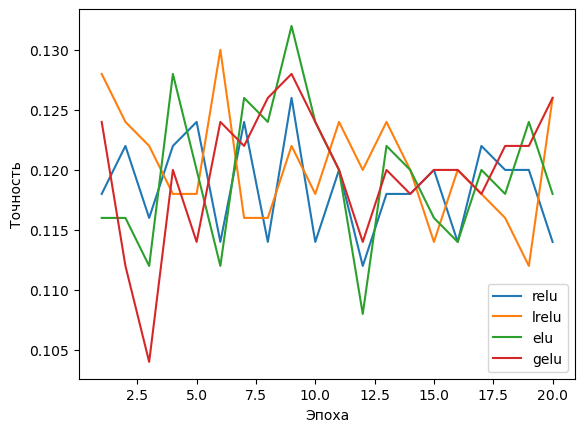

In [ ]:
plt.plot(np.arange(1, len(relu_val_acc)+1, dtype=np.uint16), relu_val_acc, label='relu')
plt.plot(np.arange(1, len(lrelu_val_acc)+1, dtype=np.uint16), lrelu_val_acc, label='lrelu')
plt.plot(np.arange(1, len(elu_val_acc)+1, dtype=np.uint16), elu_val_acc, label='elu')
plt.plot(np.arange(1, len(gelu_val_acc)+1, dtype=np.uint16), gelu_val_acc, label='gelu')
plt.legend()
plt.xlabel("Эпоха")
plt.ylabel("Точность")

Text(0, 0.5, 'Точность')

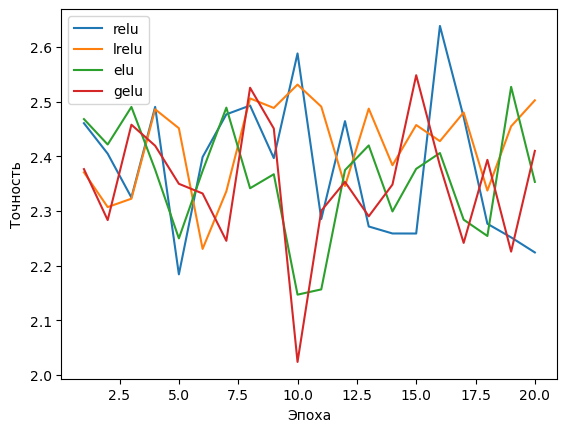

In [ ]:
plt.plot(np.arange(1, len(relu_train_loss)+1, dtype=np.uint16), relu_train_loss, label='relu')
plt.plot(np.arange(1, len(lrelu_train_loss)+1, dtype=np.uint16), lrelu_train_loss, label='lrelu')
plt.plot(np.arange(1, len(elu_train_loss)+1, dtype=np.uint16), elu_train_loss, label='elu')
plt.plot(np.arange(1, len(gelu_train_loss)+1, dtype=np.uint16), gelu_train_loss, label='gelu')
plt.legend()
plt.xlabel("Эпоха")
plt.ylabel("Точность")